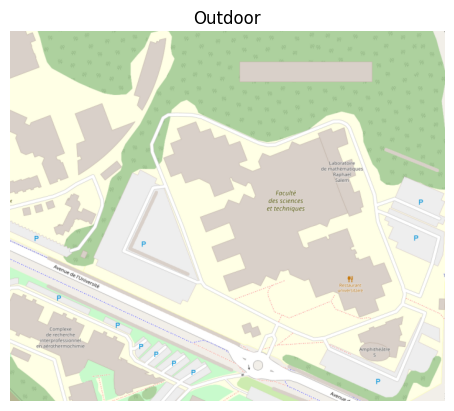

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_path = 'TP2_images/outdoorMap.png'
image = cv2.imread(image_path)


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image_rgb)
plt.title('Outdoor')
plt.axis('off')  # masquer les axes
plt.show()

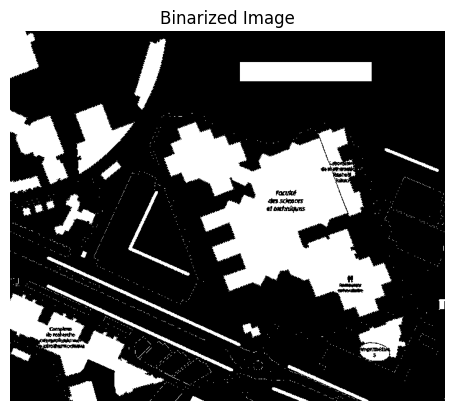

In [2]:
# On va definir la couleur des murs selon la description donnée, avec une marge pour la compression
# Nous prenons une marge de 10 pour les variations dues à la compression
wall_color = np.array([217, 208, 201])  # Couleur des murs
color_margin = np.array([10, 10, 10])


seuil_bas = wall_color - color_margin
seuil_haut = wall_color + color_margin

#les murs seront en blanc, le reste en noir
binarized_image = cv2.inRange(image_rgb, seuil_bas, seuil_haut)

plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.axis('off')  
plt.show()

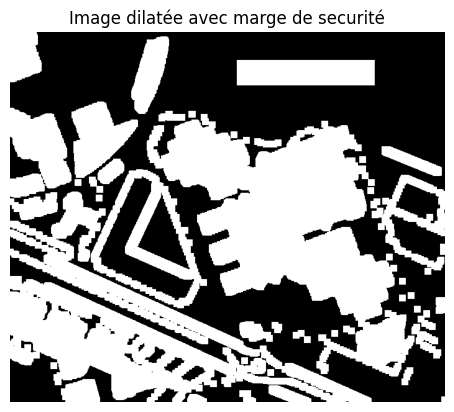

In [3]:
kernel_size = 11
kernel = np.ones((kernel_size, kernel_size), np.uint8)

dilated_image = cv2.dilate(binarized_image, kernel)

plt.imshow(dilated_image, cmap='gray')
plt.title('Image dilatée avec marge de securité')
plt.axis('off') 
plt.show()

## Fonction pour le parcours de graphe

In [4]:
def graph_traversal(start, end, map_array):
    
    distance_map = np.full(map_array.shape, np.inf)
    distance_map[start] = 0
    list_points = [start]
    directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    
    while list_points:
        current_point = list_points.pop(0)
        current_distance = distance_map[current_point]
        
        for dx, dy in directions:
            neighbor = (current_point[0] + dx, current_point[1] + dy)
            if (0 <= neighbor[0] < map_array.shape[0] and
                0 <= neighbor[1] < map_array.shape[1] and
                map_array[neighbor] == 0):
                if current_distance + 1 < distance_map[neighbor]:
                    distance_map[neighbor] = current_distance + 1
                    list_points.append(neighbor)
    
    return distance_map

### Définition de la fonction de conversion d'image en niveaux de gris et en matrice binaire

In [8]:
def convert_to_binary_map(image_array, threshold=128):
    binary_map = (image_array > threshold).astype(np.int_)
    return binary_map

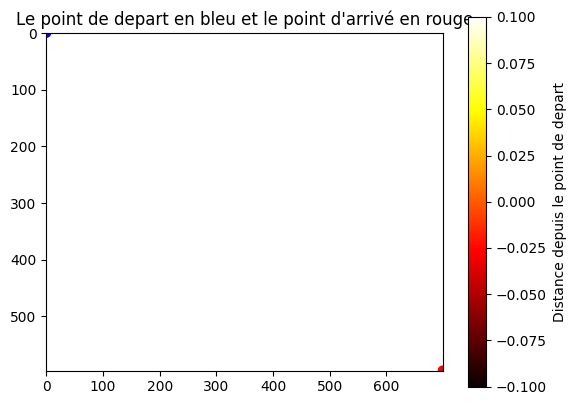

In [18]:
image_path = 'TP2_images/outdoorMap.png'
outdoor_map_img = Image.open(image_path).convert("L")
outdoor_map_array = np.array(outdoor_map_img)
binary_outdoor_map = convert_to_binary_map(outdoor_map_array)

# Apres avoir converti l'image de la map en niveaux de gris et le transformer en matrice je definis ici les points de départ et d'arrivée et parcours le graphe
point_start = (0, 0)
point_end = (binary_outdoor_map.shape[0] - 1, binary_outdoor_map.shape[1] - 1)

distance_map = graph_traversal(point_start, point_end, binary_outdoor_map)

plt.imshow(distance_map, cmap='hot')
plt.colorbar(label='Distance depuis le point de depart')
plt.scatter([point_start[1], point_end[1]], [point_start[0], point_end[0]], c=['blue', 'red'])
plt.title("Le point de depart en bleu et le point d'arrivé en rouge")
plt.show()


### ALGORITH A*

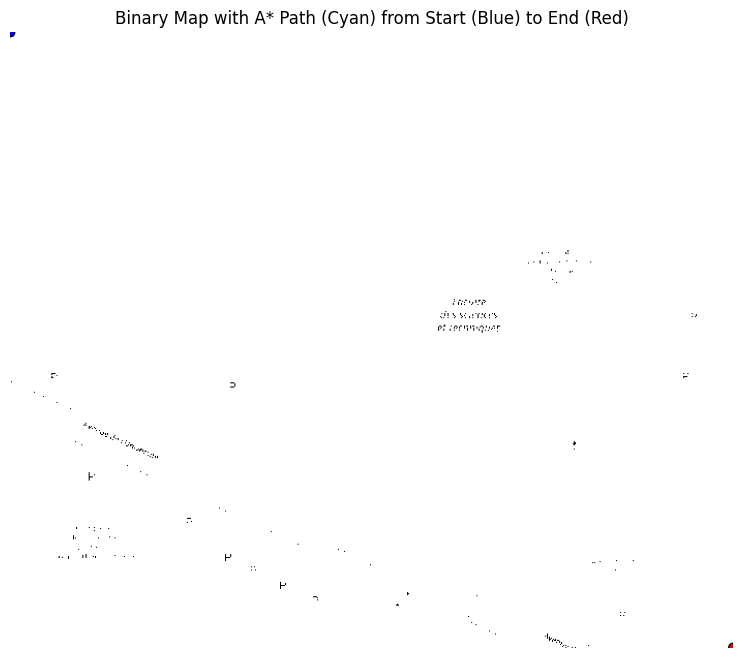

In [20]:
import heapq

def a_star_search(start, end, map_array):
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 4-connexité
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, end)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))
    
    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < map_array.shape[0]:
                if 0 <= neighbor[1] < map_array.shape[1]:                
                    if map_array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    continue
            else:
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, end)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
                
    return False

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

image_path = 'TP2_images/outdoorMap.png'
outdoor_map_img = Image.open(image_path).convert("L")
outdoor_map_array = np.array(outdoor_map_img)
binary_outdoor_map = convert_to_binary_map(outdoor_map_array)

point_start = (0, 0)
point_end = (binary_outdoor_map.shape[0] - 1, binary_outdoor_map.shape[1] - 1)

path = a_star_search(point_start, point_end, binary_outdoor_map)

plt.figure(figsize=(10, 8))
plt.imshow(binary_outdoor_map, cmap='gray')

if path:
    ys, xs = zip(*path)
    plt.plot(xs, ys, color='cyan', linewidth=2)  
plt.scatter([point_start[1], point_end[1]], [point_start[0], point_end[0]], c=['blue', 'red'], edgecolors='black')
plt.title("Binary Map with A* Path (Cyan) from Start (Blue) to End (Red)")
plt.axis('off')
plt.show()


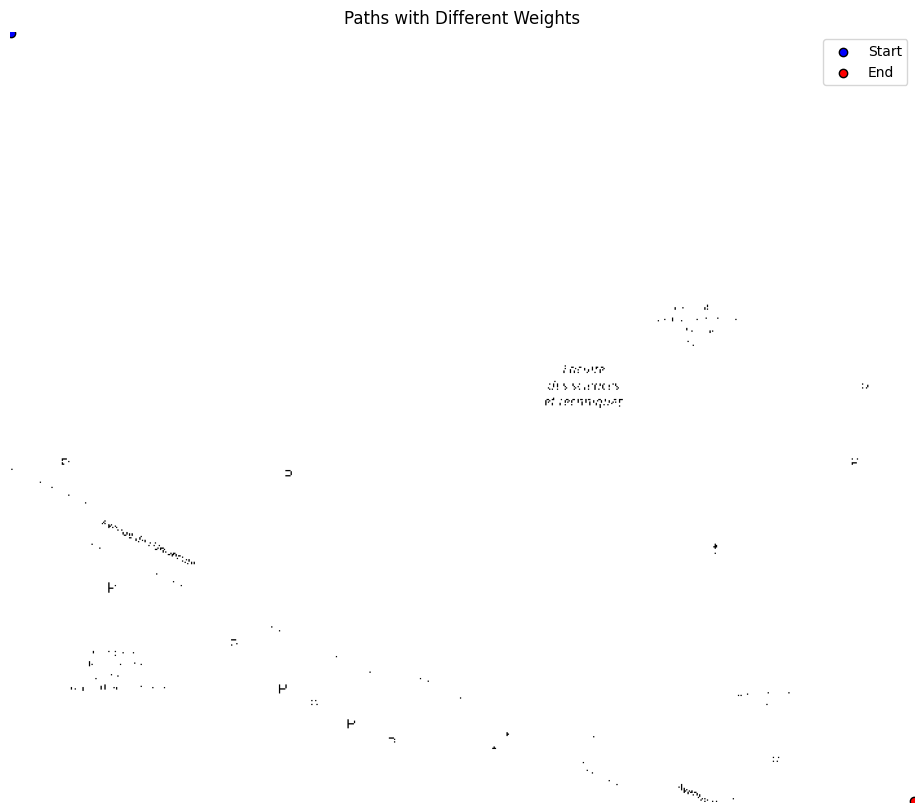

In [14]:
def weighted_heuristic(a, b, weight=1):
    return weight * (abs(a[0] - b[0]) + abs(a[1] - b[1]))

def weighted_a_star_search(start, end, map_array, weight):
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 4-connectivity
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: weighted_heuristic(start, end, weight)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))
    
    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1
            if 0 <= neighbor[0] < map_array.shape[0] and 0 <= neighbor[1] < map_array.shape[1] and map_array[neighbor] == 0:
                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue
                if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + weighted_heuristic(neighbor, end, weight)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))
    return False

weights = [1, 1.5, 2, 5, 10]
paths = {}

for weight in weights:
    path = weighted_a_star_search(point_start, point_end, binary_outdoor_map, weight)
    paths[weight] = path


plt.figure(figsize=(14, 10))
plt.imshow(binary_outdoor_map, cmap='gray')

for weight, path in paths.items():
    if path:
        ys, xs = zip(*path)
        plt.plot(xs, ys, label=f'Weight {weight}')

plt.scatter([point_start[1]], [point_start[0]], c='blue', edgecolors='black', label='Start')
plt.scatter([point_end[1]], [point_end[0]], c='red', edgecolors='black', label='End')
plt.legend()
plt.title("Paths with Different Weights")
plt.axis('off')
plt.show()
